<a href="https://colab.research.google.com/github/Mervvick/AI_Timeline_UltraPro/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22%D0%91%D0%B0%D0%B7%D0%BE%D0%B2%D1%8B%D0%B9_%D0%B1%D0%BB%D0%BE%D0%BA_%7C_%D0%9E%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B0_%D0%B2%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D1%85_%D1%80%D1%8F%D0%B4%D0%BE%D0%B2_%D1%81_%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C%D1%8E_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D1%85_%D1%81%D0%B5%D1%82%D0%B5%D0%B9_%7C_%D0%94%D0%97_Ultra_Pro_%7C_%D0%A3%D0%98%D0%98%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Используйте базу трафика с сайта компании.

Напишите модель для прогнозирования трафика.

При параметре `length = 60`, добейтесь максимально точного соответствия между графиками корреляции исходного сигнала и прогноза.

In [ ]:
# Работа с массивами
import numpy as np

# Работа с таблицами
import pandas as pd

# Классы-конструкторы моделей нейронных сетей
from tensorflow.keras.models import Sequential, Model, load_model

# Основные слои
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, LSTM, MaxPooling1D

# Оптимизаторы
from tensorflow.keras.optimizers import Adam

# Callback
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Генератор выборки временных рядов
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Нормировщики
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Коллбэк
from tensorflow.keras.callbacks import LearningRateScheduler

# Загрузка датасетов из облака google
import gdown

# Отрисовка графиков
import matplotlib.pyplot as plt

# Отрисовка графики в ячейке colab
%matplotlib inline

# Отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

# Обработка данных

In [ ]:
#Загружаем базу трафика с сайта компании
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l11/traff.csv', None, quiet=True)

'traff.csv'

In [ ]:
df = pd.read_csv('traff.csv')
df

,1/1/2017,"22,226.00"
0,1/2/2017,"29,593.00"
1,1/3/2017,"31,726.00"
2,1/4/2017,"32,684.00"
3,1/5/2017,"31,820.00"
4,1/6/2017,"29,354.00"
...,...,...
1089,12/27/2019,"29,801.00"
1090,12/28/2019,"34,913.00"
1091,12/29/2019,"37,665.00"
1092,12/30/2019,"32,643.00"


In [ ]:
df.columns = ['date', 'value']
df.value = df.value.str.replace(',', '').astype('float')
df

,date,value
0,1/2/2017,29593.0
1,1/3/2017,31726.0
2,1/4/2017,32684.0
3,1/5/2017,31820.0
4,1/6/2017,29354.0
...,...,...
1089,12/27/2019,29801.0
1090,12/28/2019,34913.0
1091,12/29/2019,37665.0
1092,12/30/2019,32643.0


In [ ]:
data = np.reshape(np.array(df['value']), (-1, 1))
data.shape

(1094, 1)

# Формирование выборок

In [ ]:
SEQ_LEN = 60
TEST_LEN = 300
TRAIN_LEN = data.shape[0] - TEST_LEN
BATCH_SIZE = 10

In [ ]:
x_train = data[: TRAIN_LEN]
x_test = data[TRAIN_LEN + SEQ_LEN + 2 :]

x_scaler = MinMaxScaler()
x_scaler.fit(x_train)
x_train = x_scaler.transform(x_train)
x_test = x_scaler.transform(x_test)

y_train = np.reshape(data[: TRAIN_LEN], (-1, 1))
y_test = np.reshape(data[TRAIN_LEN + SEQ_LEN + 2 :], (-1, 1))

y_scaler = MinMaxScaler()
y_scaler.fit(y_train)
y_train = y_scaler.transform(y_train)
y_test = y_scaler.transform(y_test)

In [ ]:
train_datagen = TimeseriesGenerator(x_train,
                                    y_train,
                                    length = SEQ_LEN,
                                    batch_size = BATCH_SIZE)

val_datagen = TimeseriesGenerator(x_test,
                                  y_test,
                                  length = SEQ_LEN,
                                  batch_size = BATCH_SIZE)

test_datagen = TimeseriesGenerator(x_test,
                                   y_test,
                                   length = SEQ_LEN,
                                   batch_size = x_test.shape[0])

x_test, y_test = test_datagen[0]

In [ ]:
print(train_datagen[0][0].shape, train_datagen[0][0].shape)
print(x_test.shape, y_test.shape)

(10, 60, 1) (10, 60, 1)
(178, 60, 1) (178, 1)


# Сервисные функции

In [ ]:
def get_pred(model,
             x_test,
             y_test,
             y_scaler):

    pred = model.predict(x_test)
    y_pred_unscaled = y_scaler.inverse_transform(pred)
    y_test_unscaled = y_scaler.inverse_transform(y_test)

    return y_pred_unscaled, y_test_unscaled

def show_pred(y_pred,
              y_true,
              start,
              length = 1000,
              chn = 0):

    plt.figure(figsize=(22, 6))

    plt.plot(y_pred[start : start + length, chn], label=f'Прогноз')
    plt.plot(y_true[start : start + length, chn], label=f'База')

    plt.xlabel('Время')
    plt.ylabel('Данные')
    plt.legend()
    plt.show()

def show_corr(y_pred,
              y_true,
              steps,
              channels = [0]):

    y_len = y_true.shape[0]

    for channel in channels:
        cross_corr = [np.corrcoef(y_true[:y_len - step, channel], y_pred[step:, channel])[0, 1] for step in range(steps+1)]
        auto_corr = [np.corrcoef(y_true[:y_len - step, channel], y_true[step:, channel])[0, 1] for step in range(steps+1)]

        plt.plot(cross_corr, label = f'Прогноз')
        plt.plot(auto_corr, label = 'Эталон')


    plt.xlabel('Шаги смещения')
    plt.ylabel('Коэффициент корреляции')
    plt.legend()
    plt.show()

In [ ]:
callback = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patiecnce = 2)

# Модель №1

Epoch 1/100
74/74 [==============================] - 1s 5ms/step - loss: 0.0265 - val_loss: 0.0227 - lr: 1.0000e-04
Epoch 2/100
74/74 [==============================] - 0s 3ms/step - loss: 0.0104 - val_loss: 0.0226 - lr: 1.0000e-04
Epoch 3/100
74/74 [==============================] - 0s 3ms/step - loss: 0.0087 - val_loss: 0.0111 - lr: 1.0000e-04
Epoch 4/100
74/74 [==============================] - 0s 4ms/step - loss: 0.0074 - val_loss: 0.0136 - lr: 1.0000e-04
Epoch 5/100
74/74 [==============================] - 0s 4ms/step - loss: 0.0068 - val_loss: 0.0136 - lr: 1.0000e-04
Epoch 6/100
74/74 [==============================] - 0s 4ms/step - loss: 0.0060 - val_loss: 0.0088 - lr: 1.0000e-04
Epoch 7/100
74/74 [==============================] - 0s 3ms/step - loss: 0.0057 - val_loss: 0.0068 - lr: 1.0000e-04
Epoch 8/100
74/74 [==============================] - 0s 3ms/step - loss: 0.0057 - val_loss: 0.0068 - lr: 1.0000e-04
Epoch 9/100
74/74 [==============================] - 0s 3ms/step - loss:

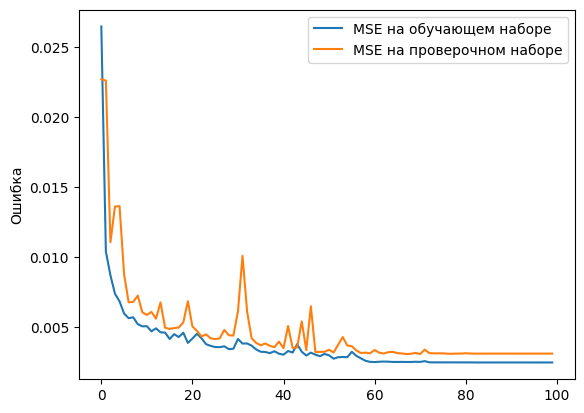

In [ ]:
model1 = Sequential()

model1.add(Dense(150, input_shape = (SEQ_LEN, data.shape[1]), activation = "linear" ))
model1.add(Flatten())
model1.add(Dense(1, activation = "linear"))

model1.compile(loss = "mse", optimizer = Adam(0.0001))

history = model1.fit_generator(train_datagen,
                              epochs = 100,
                              verbose = 1,
                              validation_data = val_datagen,
                              callbacks = [callback]
                              )

model1.save('/content/drive/MyDrive/AI/models/timeline_Ultra_Pro_1')

plt.plot(history.history['loss'], label = 'MSE на обучающем наборе')
plt.plot(history.history['val_loss'], label = 'MSE на проверочном наборе')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

6/6 [==============================] - 0s 3ms/step


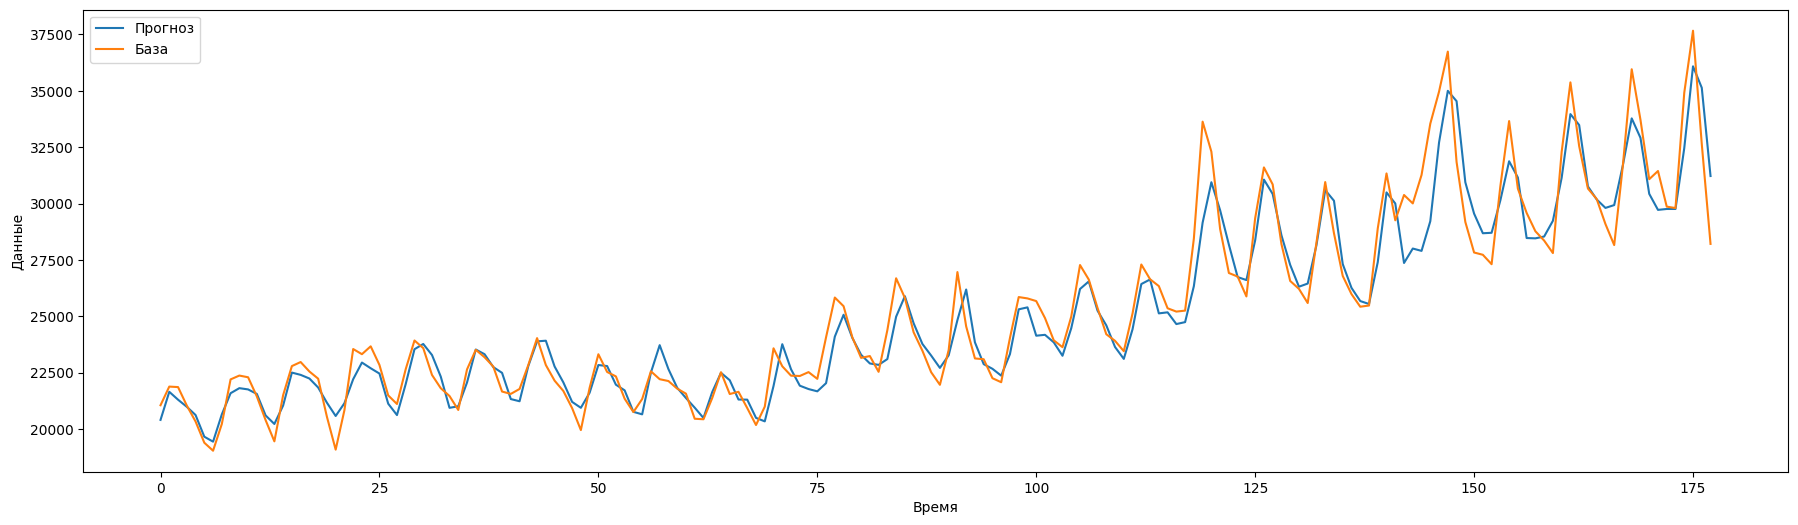

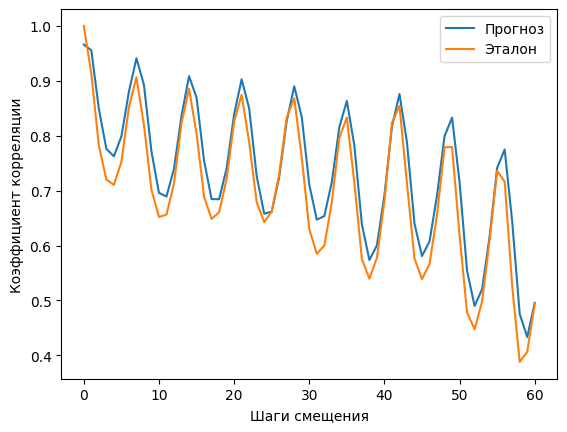

In [ ]:
pred = get_pred(model1, x_test, y_test, y_scaler)
show_pred(pred[0], pred[1], 0, 178)
show_corr(pred[0], pred[1], 60)

# Модель №2

Epoch 1/100
74/74 [==============================] - 1s 5ms/step - loss: 0.0336 - val_loss: 0.0331 - lr: 1.0000e-04
Epoch 2/100
74/74 [==============================] - 0s 4ms/step - loss: 0.0099 - val_loss: 0.0184 - lr: 1.0000e-04
Epoch 3/100
74/74 [==============================] - 0s 3ms/step - loss: 0.0082 - val_loss: 0.0109 - lr: 1.0000e-04
Epoch 4/100
74/74 [==============================] - 0s 3ms/step - loss: 0.0097 - val_loss: 0.0103 - lr: 1.0000e-04
Epoch 5/100
74/74 [==============================] - 0s 3ms/step - loss: 0.0081 - val_loss: 0.0125 - lr: 1.0000e-04
Epoch 6/100
74/74 [==============================] - 0s 3ms/step - loss: 0.0066 - val_loss: 0.0074 - lr: 1.0000e-04
Epoch 7/100
74/74 [==============================] - 0s 3ms/step - loss: 0.0060 - val_loss: 0.0061 - lr: 1.0000e-04
Epoch 8/100
74/74 [==============================] - 0s 4ms/step - loss: 0.0060 - val_loss: 0.0066 - lr: 1.0000e-04
Epoch 9/100
74/74 [==============================] - 0s 3ms/step - loss:

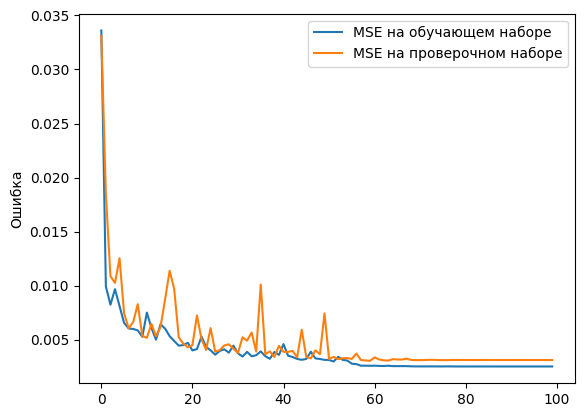

In [ ]:
model2 = Sequential()

model2.add(Conv1D(50, 5, input_shape = (SEQ_LEN, data.shape[1]), activation = 'linear'))
model2.add(Flatten())
model2.add(Dense(10, activation = 'linear'))
model2.add(Dense(y_test.shape[1], activation = 'linear'))

model2.compile(loss = "mse", optimizer = Adam(0.0001))

history = model2.fit_generator(train_datagen,
                               epochs = 100,
                               verbose = 1,
                               validation_data = val_datagen,
                               callbacks = [callback]
                               )

model2.save('/content/drive/MyDrive/AI/models/timeline_Ultra_Pro_2')

plt.plot(history.history['loss'], label = 'MSE на обучающем наборе')
plt.plot(history.history['val_loss'], label = 'MSE на проверочном наборе')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

6/6 [==============================] - 0s 3ms/step


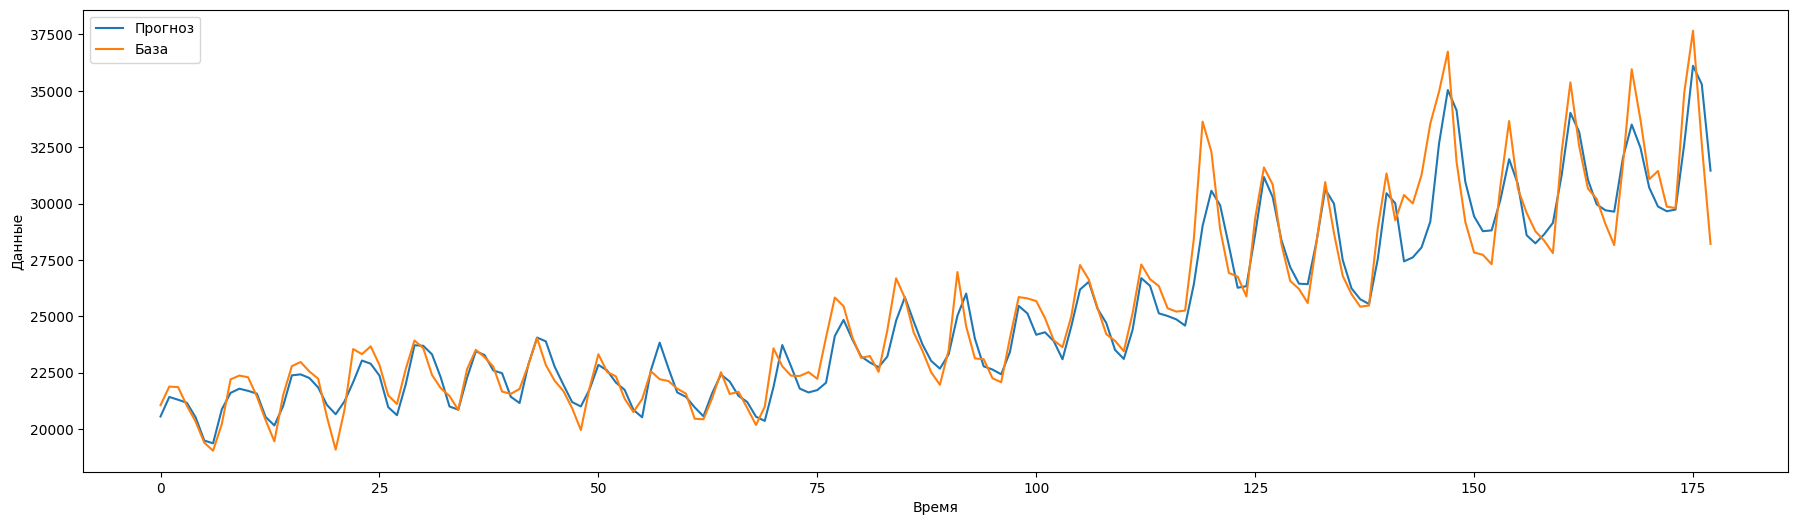

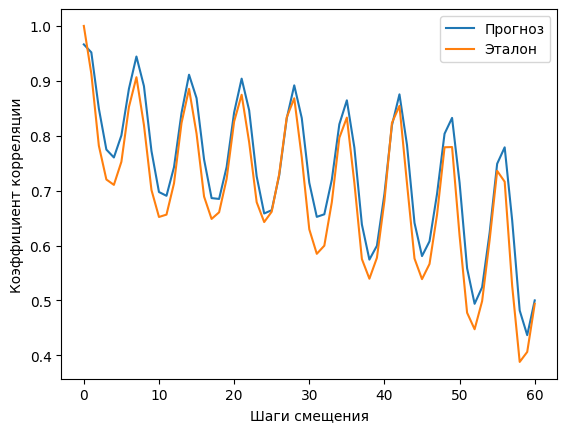

In [ ]:
pred = get_pred(model2, x_test, y_test, y_scaler)
show_pred(pred[0], pred[1], 0, 178)
show_corr(pred[0], pred[1], 60)

# Модель №3

Epoch 1/50
74/74 [==============================] - 5s 32ms/step - loss: 0.0652 - val_loss: 0.1149 - lr: 1.0000e-04
Epoch 2/50
74/74 [==============================] - 2s 24ms/step - loss: 0.0415 - val_loss: 0.0799 - lr: 1.0000e-04
Epoch 3/50
74/74 [==============================] - 2s 24ms/step - loss: 0.0273 - val_loss: 0.0575 - lr: 1.0000e-04
Epoch 4/50
74/74 [==============================] - 2s 24ms/step - loss: 0.0188 - val_loss: 0.0416 - lr: 1.0000e-04
Epoch 5/50
74/74 [==============================] - 2s 32ms/step - loss: 0.0142 - val_loss: 0.0322 - lr: 1.0000e-04
Epoch 6/50
74/74 [==============================] - 2s 24ms/step - loss: 0.0121 - val_loss: 0.0268 - lr: 1.0000e-04
Epoch 7/50
74/74 [==============================] - 2s 31ms/step - loss: 0.0110 - val_loss: 0.0236 - lr: 1.0000e-04
Epoch 8/50
74/74 [==============================] - 2s 29ms/step - loss: 0.0103 - val_loss: 0.0214 - lr: 1.0000e-04
Epoch 9/50
74/74 [==============================] - 2s 25ms/step - loss:

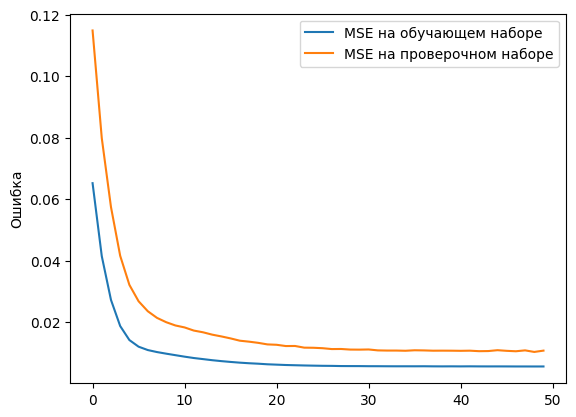

In [ ]:
model3 = Sequential()
model3.add(LSTM(5, input_shape = (SEQ_LEN, data.shape[1])))
model3.add(Dense(10, activation = 'relu'))
model3.add(Dense(y_test.shape[1], activation='linear'))

model3.compile(loss = "mse", optimizer = Adam(0.0001))

history = model3.fit_generator(train_datagen,
                               epochs = 50,
                               verbose = 1,
                               validation_data = val_datagen,
                               callbacks = [callback]
                               )

model2.save('/content/drive/MyDrive/AI/models/timeline_Ultra_Pro_3')

plt.plot(history.history['loss'], label = 'MSE на обучающем наборе')
plt.plot(history.history['val_loss'], label = 'MSE на проверочном наборе')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

6/6 [==============================] - 2s 13ms/step


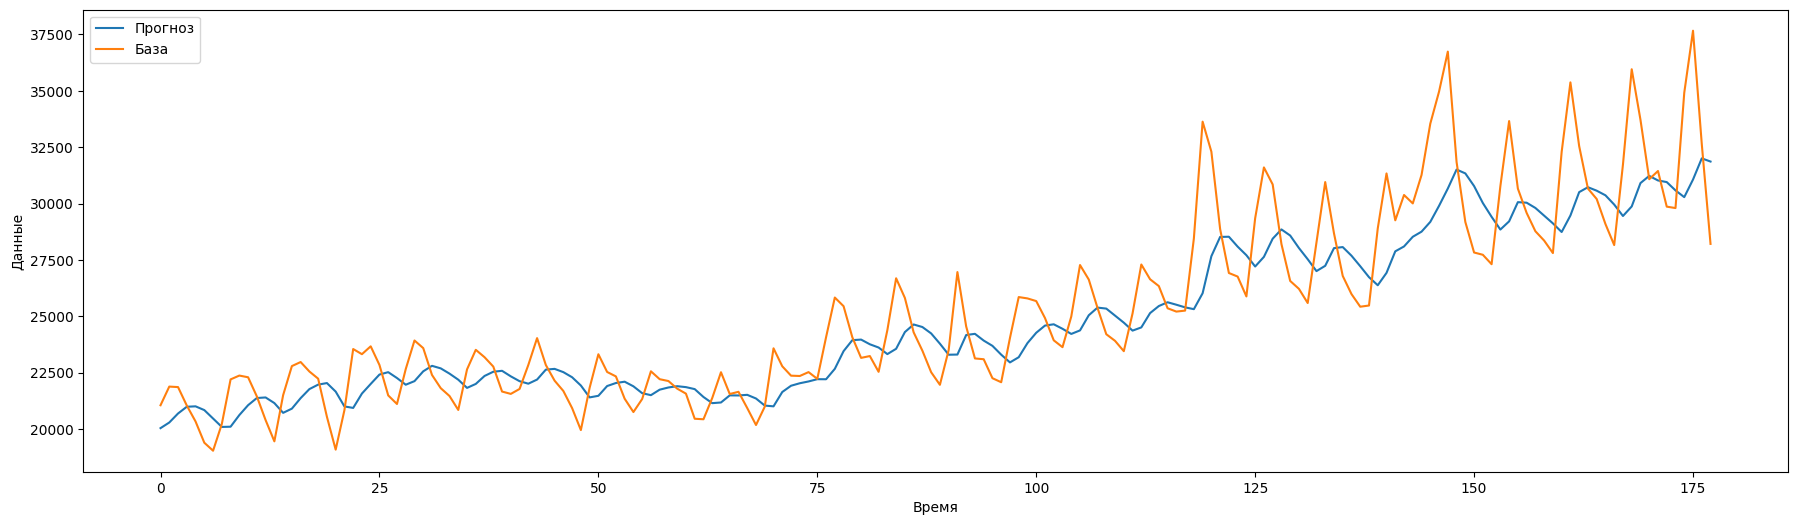

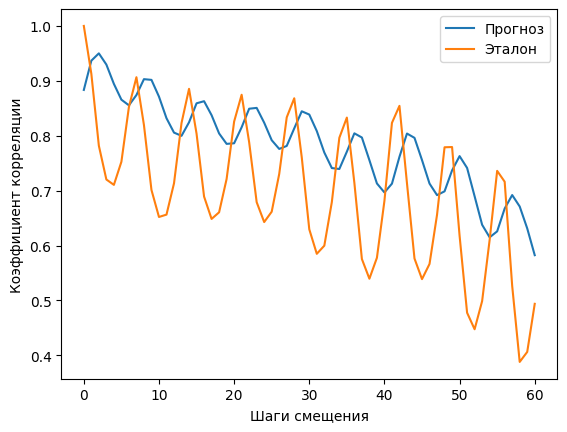

In [ ]:
pred = get_pred(model3, x_test, y_test, y_scaler)
show_pred(pred[0], pred[1], 0, 178)
show_corr(pred[0], pred[1], 60)